# LOAN DEFAULT CLASSIFICATION PROJECT

The purpose of the project is to analyze both visually and descriptively the Loan Default dataset from Kaggle.com that contains more than 100k rows  regarding mortgages stipulated in India. 

The dataset presents highly correlated variables and many null values that will also need to be taken care of.

Lastly, we're interested in developing a machine learning model that can predict whether the loan defaulted or not. In order to do so, we'll try different classification models and compare their results through various accuracy metrics and confusion matrices.

Let's start by importing the required libraries.

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, jaccard_score
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("D:/Utente/Documenti/datasets/Loan_Default.csv")
pd.set_option('display.max_columns', 500)
df.head()

,ID,year,loan_limit,Gender,approv_in_adv,loan_type,loan_purpose,Credit_Worthiness,open_credit,business_or_commercial,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,term,Neg_ammortization,interest_only,lump_sum_payment,property_value,construction_type,occupancy_type,Secured_by,total_units,income,credit_type,Credit_Score,co-applicant_credit_type,age,submission_of_application,LTV,Region,Security_Type,Status,dtir1
0,24890,2019,cf,Sex Not Available,nopre,type1,p1,l1,nopc,nob/c,116500,NaN,NaN,NaN,360.0,not_neg,not_int,not_lpsm,118000.0,sb,pr,home,1U,1740.0,EXP,758,CIB,25-34,to_inst,98.728814,south,direct,1,45.0
1,24891,2019,cf,Male,nopre,type2,p1,l1,nopc,b/c,206500,NaN,NaN,NaN,360.0,not_neg,not_int,lpsm,NaN,sb,pr,home,1U,4980.0,EQUI,552,EXP,55-64,to_inst,NaN,North,direct,1,NaN
2,24892,2019,cf,Male,pre,type1,p1,l1,nopc,nob/c,406500,4.56,0.2000,595.0,360.0,neg_amm,not_int,not_lpsm,508000.0,sb,pr,home,1U,9480.0,EXP,834,CIB,35-44,to_inst,80.019685,south,direct,0,46.0
3,24893,2019,cf,Male,nopre,type1,p4,l1,nopc,nob/c,456500,4.25,0.6810,NaN,360.0,not_neg,not_int,not_lpsm,658000.0,sb,pr,home,1U,11880.0,EXP,587,CIB,45-54,not_inst,69.376900,North,direct,0,42.0
4,24894,2019,cf,Joint,pre,type1,p1,l1,nopc,nob/c,696500,4.00,0.3042,0.0,360.0,not_neg,not_int,not_lpsm,758000.0,sb,pr,home,1U,10440.0,CRIF,602,EXP,25-34,not_inst,91.886544,North,direct,0,39.0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 34 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   ID                         148670 non-null  int64  
 1   year                       148670 non-null  int64  
 2   loan_limit                 145326 non-null  object 
 3   Gender                     148670 non-null  object 
 4   approv_in_adv              147762 non-null  object 
 5   loan_type                  148670 non-null  object 
 6   loan_purpose               148536 non-null  object 
 7   Credit_Worthiness          148670 non-null  object 
 8   open_credit                148670 non-null  object 
 9   business_or_commercial     148670 non-null  object 
 10  loan_amount                148670 non-null  int64  
 11  rate_of_interest           112231 non-null  float64
 12  Interest_rate_spread       112031 non-null  float64
 13  Upfront_charges            10

There appear to be many null values, we'll address the problem later.

Some notes:
- loan_limit: conforming loans have lower interest rates than non conforming loans
- gender: joint means there are more than one borrower 
- credit_type: credit information company 
- LTV: loan to value
- security type: whether there are assets as collateral (direct) or other forms or guarantee (indirect)
- status: 0=not defaulted, 1=defaulted
- dtir: debt to income ratio

## Exploratory Data Analysis

Let us first take a look at the categorical variables in the dataset.

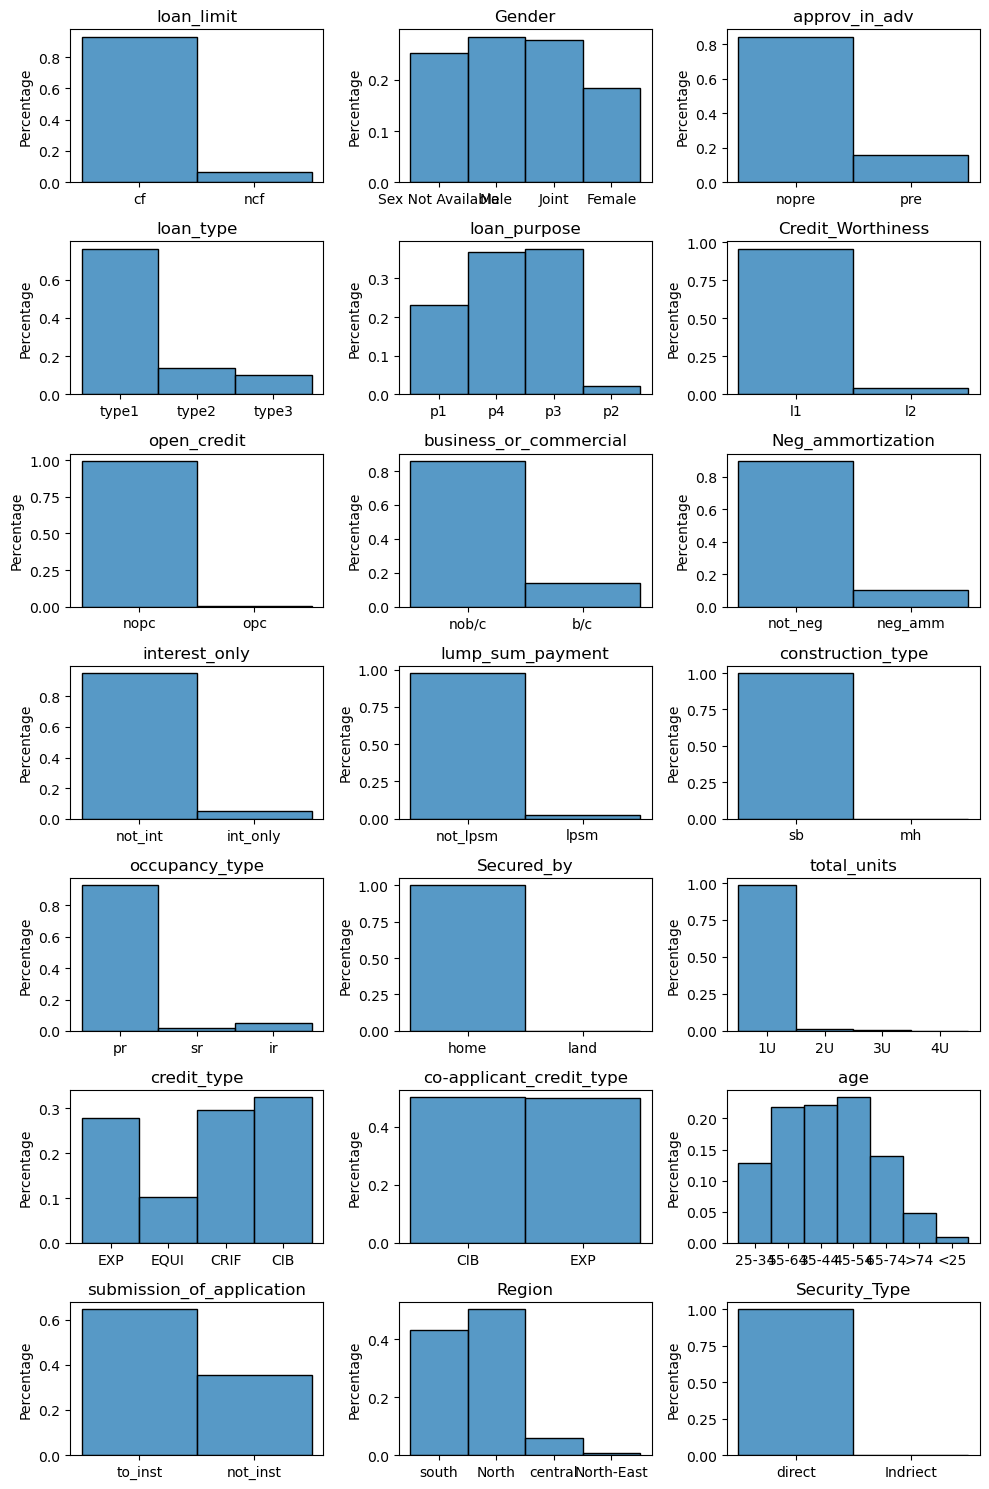

In [4]:
cat_data = df.select_dtypes("object")
cat_features = cat_data.columns

fig, axs = plt.subplots(7, 3, figsize=(10, 15))

z = 0
for i in range(7):
    for j in range(3):
        sns.histplot(x=df[cat_features[z]], stat="probability", ax=axs[i, j])
        axs[i,j].set_title(cat_features[z])
        axs[i,j].set(xlabel= None, ylabel="Percentage")
        plt.tight_layout()
        z += 1

Histogram showing the relationships between the loan status (defaulted or not), age groups and gender of the borrowers.

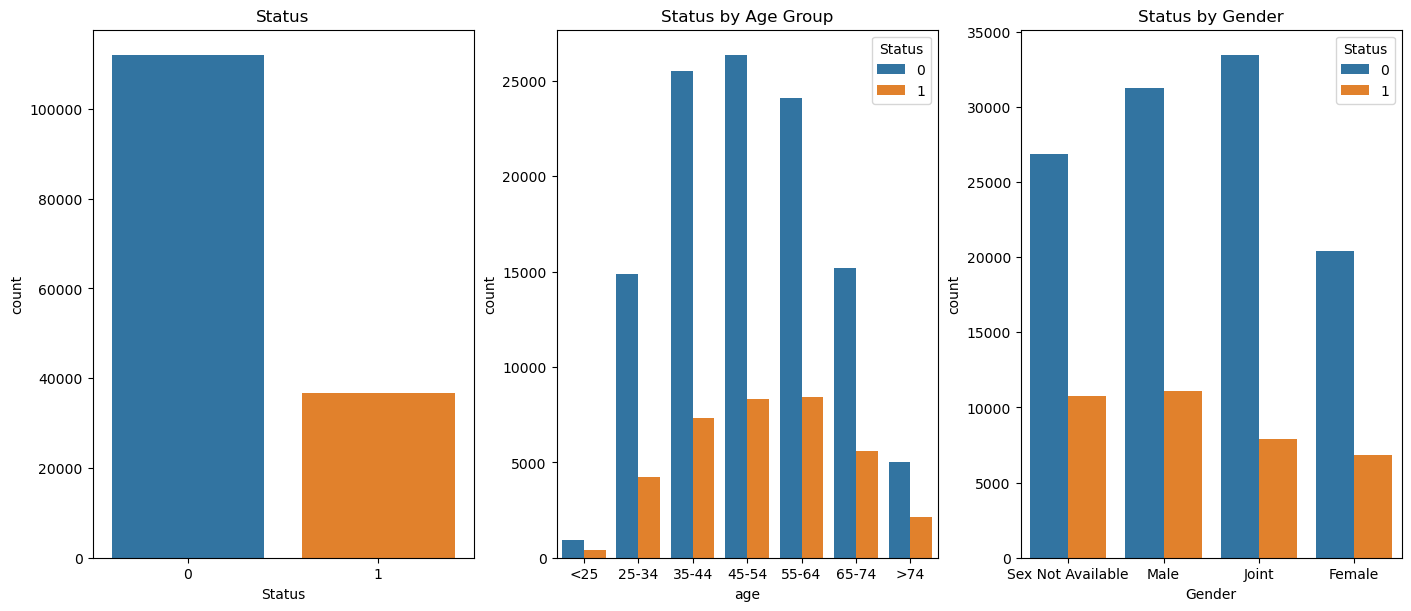

In [5]:
fig, axs = plt.subplots(1, 3, constrained_layout=True, figsize=(14, 6))


sns.countplot(x="Status", data=df, ax=axs[0])
axs[0].set_title("Status")

sns.countplot(x='age', hue='Status', order=["<25", "25-34", '35-44', '45-54', '55-64', '65-74', '>74'],
                                            data=df, ax=axs[1])
axs[1].set_title("Status by Age Group")

sns.countplot(x='Gender', hue='Status', data=df, ax=axs[2])
axs[2].set_title("Status by Gender")


plt.show()

Around a third of the loans defaulted. Younger borrowers seem slightly less inclined to default compared to older ones. Loans that were signed jointly are also less likely to default.

Now for the continous variables. <br>
Scatterplots shows the relationships between economic variables.

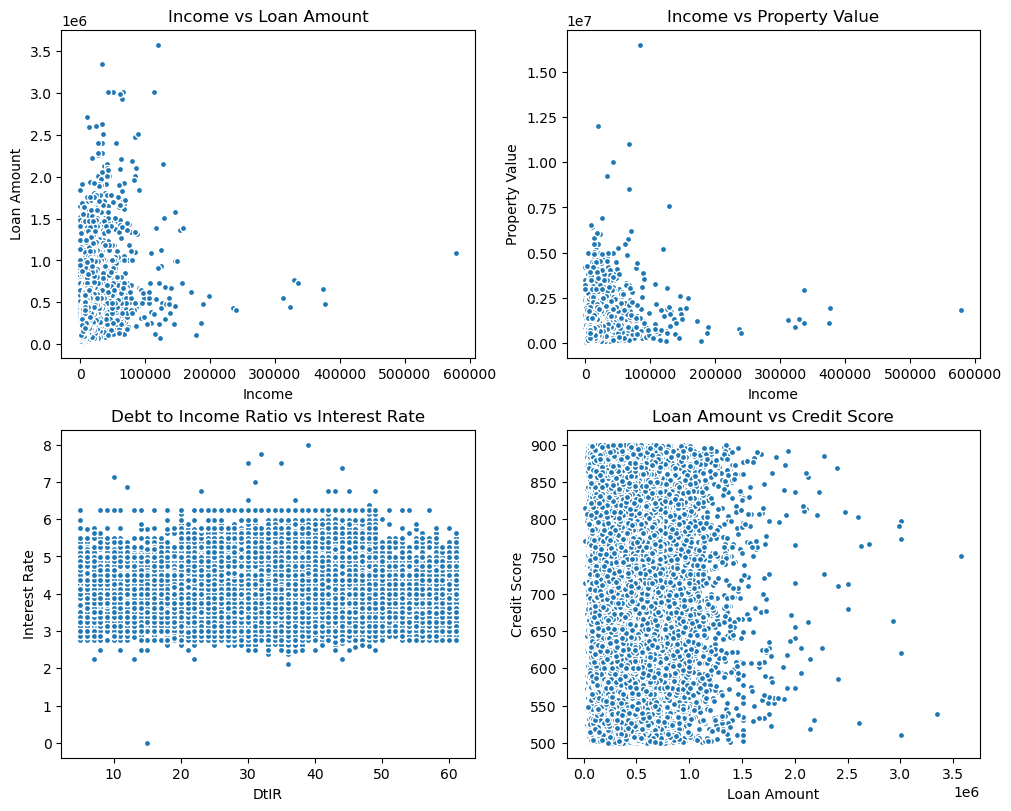

In [6]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout=True)

axs[0, 0].scatter(x="income", y="loan_amount", data=df, edgecolor="white", s=20)
axs[0, 0].set_title("Income vs Loan Amount")
axs[0, 0].set_xlabel("Income")
axs[0, 0].set_ylabel("Loan Amount")

axs[0, 1].scatter(x="income", y="property_value", data=df, edgecolor="white", s=20)
axs[0, 1].set_title("Income vs Property Value")
axs[0, 1].set_xlabel("Income")
axs[0, 1].set_ylabel("Property Value")

axs[1, 0].scatter(x="dtir1", y="rate_of_interest", data=df, edgecolor="white", s=20)
axs[1, 0].set_title("Debt to Income Ratio vs Interest Rate")
axs[1, 0].set_xlabel("DtIR")
axs[1, 0].set_ylabel("Interest Rate")

axs[1, 1].scatter(x="loan_amount", y="Credit_Score", data=df, edgecolor="white", s=20)
axs[1, 1].set_title("Loan Amount vs Credit Score")
axs[1, 1].set_xlabel("Loan Amount")
axs[1, 1].set_ylabel("Credit Score")

plt.show()

There doesn't seem to be any clear relationship between wealth and size of the loan.

Let's plot the distributions of the continous features.

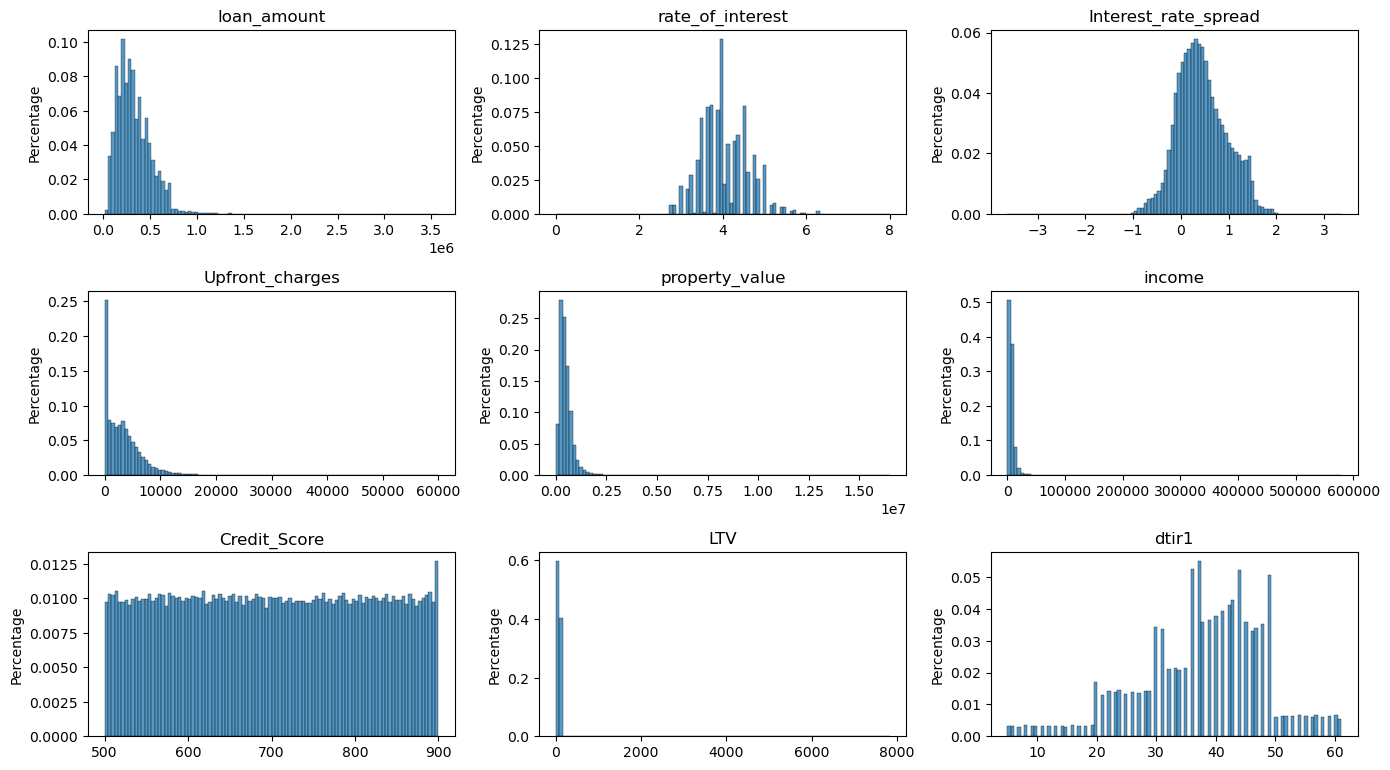

In [7]:
continous_features = df[["loan_amount", "rate_of_interest", "Interest_rate_spread", "Upfront_charges", "property_value", 
                        "income", "Credit_Score", "LTV", "dtir1"]]
fig, axs = plt.subplots(3, 3, figsize=(14,8))

z = 0
for i in range(3):
    for j in range(3):
        sns.histplot(continous_features[continous_features.columns[z]], bins=100, stat="probability", ax=axs[i,j])
        plt.tight_layout()
        axs[i,j].set_title(continous_features.columns[z])
        axs[i,j].set(xlabel=None, ylabel="Percentage")
        z+=1

There seem to be many outliers, let's have a clearer view of them with boxplots.

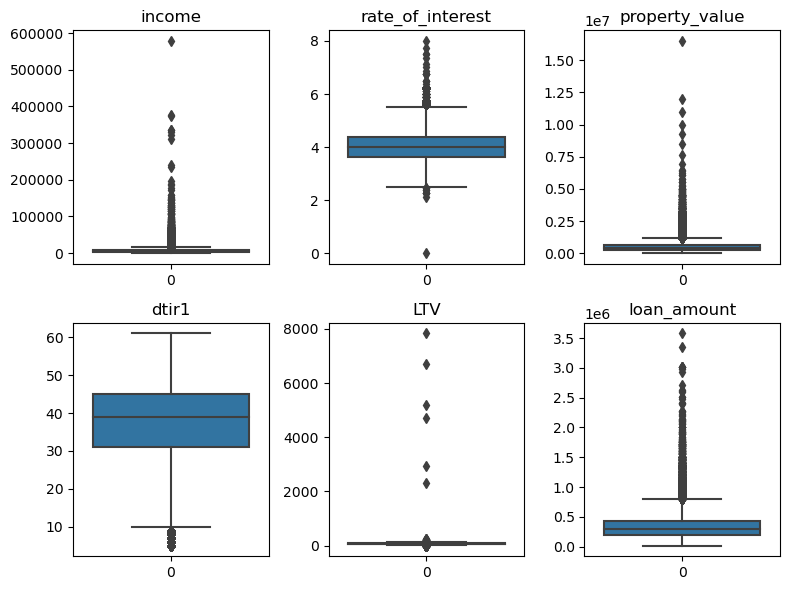

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(8,6))
boxplot_data = continous_features[["income", "rate_of_interest", "property_value", "dtir1", "LTV", "loan_amount"]]

z = 0
for i in range(2):
    for j in range(3):
        sns.boxplot(data=boxplot_data[boxplot_data.columns[z]], ax=axs[i,j])
        plt.tight_layout()
        axs[i,j].set_title(boxplot_data.columns[z])
        axs[i,j].set(xlabel=None)
        z+=1

## Feature Engineering

To implement a machine learning model we'll need to convert all of our data into numbers. We also need to get rid of the null values as well. 
We'll start by transforming the categorical variables.

Some features have only two different values, that can easily be converted into 0s and 1s. There are also multi categorical features where the most frequent value represents more than 90% of the total observations. They can be binarized as well.

In [9]:
binary_features = cat_data.columns[cat_data.nunique() == 2] 
binarizable_features = ["loan_type", "total_units", "occupancy_type"]

for bf in binarizable_features:
    binary_features = pd.Index(binary_features.tolist() + df[[bf]].columns.tolist())

for b in binary_features:
    mode = df[b].mode()[0]
    df[b] = df[b].apply(lambda x: x if pd.isnull(x) else (0 if x == mode else 1))

The other multi categorical features can be one hot encoded. We'll have to remove one column from each one hot encoded variable to avoid perfect multicollinearity.

In [10]:
multi_features = ["loan_purpose", "credit_type", "Region", "Gender"]

for m in multi_features:
    df[m] = df[m].fillna(df[m].mode()[0])
    ohe = pd.get_dummies(df[m])
    df = df.join(ohe)
    df.drop(m, axis=1, inplace=True)
    
    
df.drop(["Sex Not Available", "central", "EQUI", "p4"], axis=1, inplace=True) # drop one column for each hot encoded variable

As for the age groups, their encoding need to match their order.

In [11]:
age_mapping = {"<25":0, "25-34":1, '35-44':2, '45-54':3, '55-64':4, '65-74':5, '>74':6}
df["age"] = df["age"].map(age_mapping)

Let's plot a correlation matrix to check relationships between all the continous features.

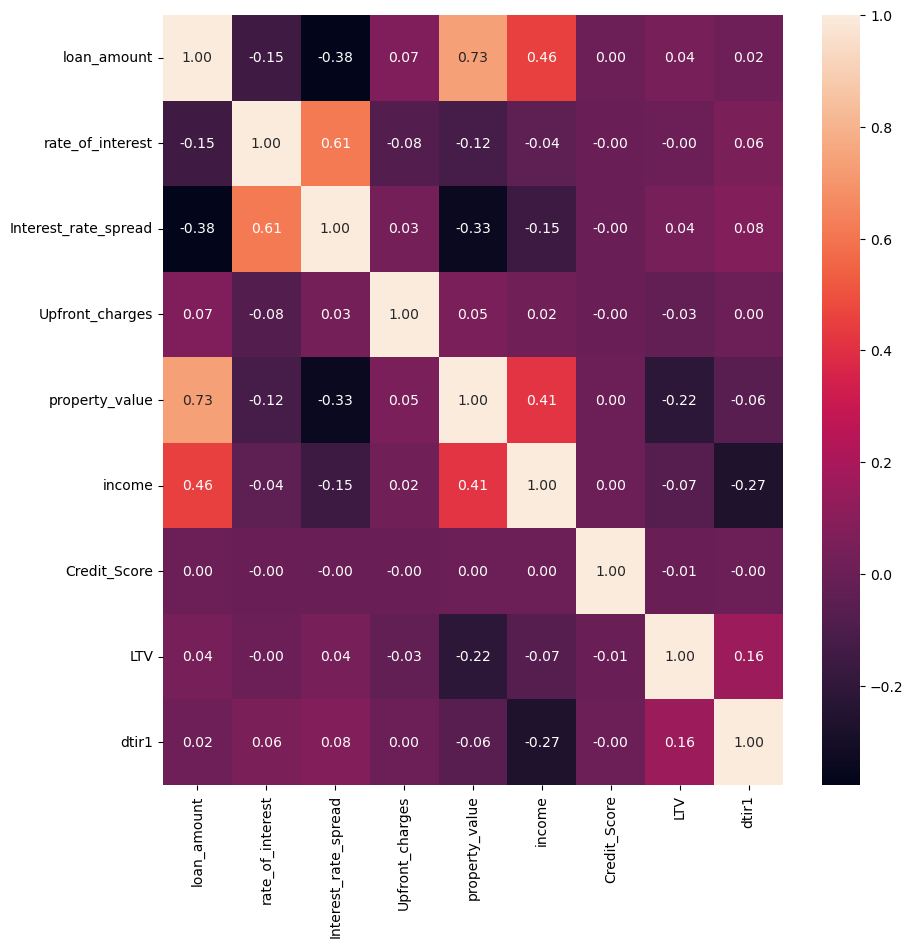

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(continous_features.corr(), annot=True, fmt=".2f")
plt.show()

Unsurprisingly, the higher the income the higher the property value and the loan amount. Also interest rate spread and rate of interest appear to be very high correlated: it is most certainly a case of multicollinearity. To stay safe, let's drop the most correlated variables.

In [13]:
df.drop(["Interest_rate_spread", "loan_amount"], axis=1, inplace=True) # highly correlated with rate of interest and property value respectively

Now we need to take care of the null values. The descriptive statistics for the continous variables can give us an idea of what imputation to make.

In [14]:
continous_features.describe()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,income,Credit_Score,LTV,dtir1
count,1.486700e+05,112231.000000,112031.000000,109028.000000,1.335720e+05,139520.000000,148670.000000,133572.000000,124549.000000
mean,3.311177e+05,4.045476,0.441656,3224.996127,4.978935e+05,6957.338876,699.789103,72.746457,37.732932
std,1.839093e+05,0.561391,0.513043,3251.121510,3.599353e+05,6496.586382,115.875857,39.967603,10.545435
min,1.650000e+04,0.000000,-3.638000,0.000000,8.000000e+03,0.000000,500.000000,0.967478,5.000000
25%,1.965000e+05,3.625000,0.076000,581.490000,2.680000e+05,3720.000000,599.000000,60.474860,31.000000
50%,2.965000e+05,3.990000,0.390400,2596.450000,4.180000e+05,5760.000000,699.000000,75.135870,39.000000
75%,4.365000e+05,4.375000,0.775400,4812.500000,6.280000e+05,8520.000000,800.000000,86.184211,45.000000
max,3.576500e+06,8.000000,3.357000,60000.000000,1.650800e+07,578580.000000,900.000000,7831.250000,61.000000


In [15]:
cols_with_nulls = df.columns[df.isnull().any()].tolist()
df[cols_with_nulls].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148670 entries, 0 to 148669
Data columns (total 12 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   loan_limit                 145326 non-null  float64
 1   approv_in_adv              147762 non-null  float64
 2   rate_of_interest           112231 non-null  float64
 3   Upfront_charges            109028 non-null  float64
 4   term                       148629 non-null  float64
 5   Neg_ammortization          148549 non-null  float64
 6   property_value             133572 non-null  float64
 7   income                     139520 non-null  float64
 8   age                        148470 non-null  float64
 9   submission_of_application  148470 non-null  float64
 10  LTV                        133572 non-null  float64
 11  dtir1                      124549 non-null  float64
dtypes: float64(12)
memory usage: 13.6 MB


For some variables, null values amount to about 20% of the data. Imputations can lead to severe distortions in our data but is it worth to drop all these rows? <br>
Let's check how many rows with null values we have in respect to the target variable Status:

In [16]:
null_cols_status_0 = df[df["Status"] == 0].isnull().sum() # we can also use isnull method both are same
null_cols_status_1 = df[df["Status"] == 1].isnull().sum() # we can also use isnull method both are same

print (f"Maximum number of null values in the class 0: {np.max(null_cols_status_0)}")
print (f"Maximum number of null values in the class 1: {np.max(null_cols_status_1)}")

Maximum number of null values in the class 0: 7911
Maximum number of null values in the class 1: 36486


If we drop all the rows with nulls we would lose basically all the rows where the target variable is 1. There is no way around it: we have to make imputations. <br>
We'll impute the median for the continous variables and the mode for the categoricals.

In [17]:
for col in cols_with_nulls:
    if col in continous_features:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna(df[col].mode()[0])
        
print("Columns with null values =", len(df.columns[df.isnull().any()].tolist()))

Columns with null values = 0


Lastly, since all of these features are on different scales we'll need to rescale them for our models to learn better.

In [18]:
std_df = df.copy()
for f in std_df[continous_features.columns.difference(["loan_amount", "Interest_rate_spread"])]:
    ss = StandardScaler()
    std_df[f] = ss.fit_transform(np.asarray(df[f]).reshape(-1, 1))

## Classification Models

Now for the machine learning part. We'll try different classification models to predict whether the client defaulted or not and we'll compare the results. But first we need to split our data.

In [19]:
Y = std_df["Status"]
X = std_df[df.columns.difference(["Status", "ID", "year"])] # also remove the irrelevant columns

In [20]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.15, random_state=1, shuffle=True, stratify=Y)

print(f"Train sample = {x_train.shape[0]}")
print(f"Test sample = {x_test.shape[0]}")

Train sample = 126369
Test sample = 22301


We'll use four different classification models: Logistic Regression, Support Vector Machines (SVM), Random Forest and KNN. <br>
For each of them we'll save three different accuracy scores and a confusion matrix object for future plotting.

In [21]:
log_reg = LogisticRegression(solver="liblinear")
svm = LinearSVC()
rf = RandomForestClassifier(n_estimators=100, criterion="gini", n_jobs=-1)
knn = KNeighborsClassifier(n_neighbors=5)

models = [log_reg, svm, rf, knn]
Accuracy = []
F1 = []
Jaccard = []
Matrices = []

for m in models:
    m.fit(x_train, y_train)
    y_pred = m.predict(x_test)
    acc=accuracy_score(y_test, y_pred)
    f1=f1_score(y_test, y_pred)
    jacc=jaccard_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    Accuracy.append(acc)
    F1.append(f1)
    Jaccard.append(jacc)
    Matrices.append(cm)

names = ["LogReg", "SVM", "RandomForest", "KNN"]
metrics = pd.DataFrame({"Model": names, 
                        "Accuracy Score":Accuracy,
                        "F1 Score":F1,
                        "Jaccard Score":Jaccard})
display(metrics)

C:\Users\Luca\anaconda3\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\Luca\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


,Model,Accuracy Score,F1 Score,Jaccard Score
0,LogReg,0.865925,0.646070,0.477181
1,SVM,0.860006,0.608772,0.437579
2,RandomForest,0.997085,0.994118,0.988305
3,KNN,0.896866,0.779016,0.638023


All three of our scores point in the same direction: the Random Forest strongly outclasses all the other models. <br>
Let's plot the confusion matrices to check how accurate the classification on the test data went.

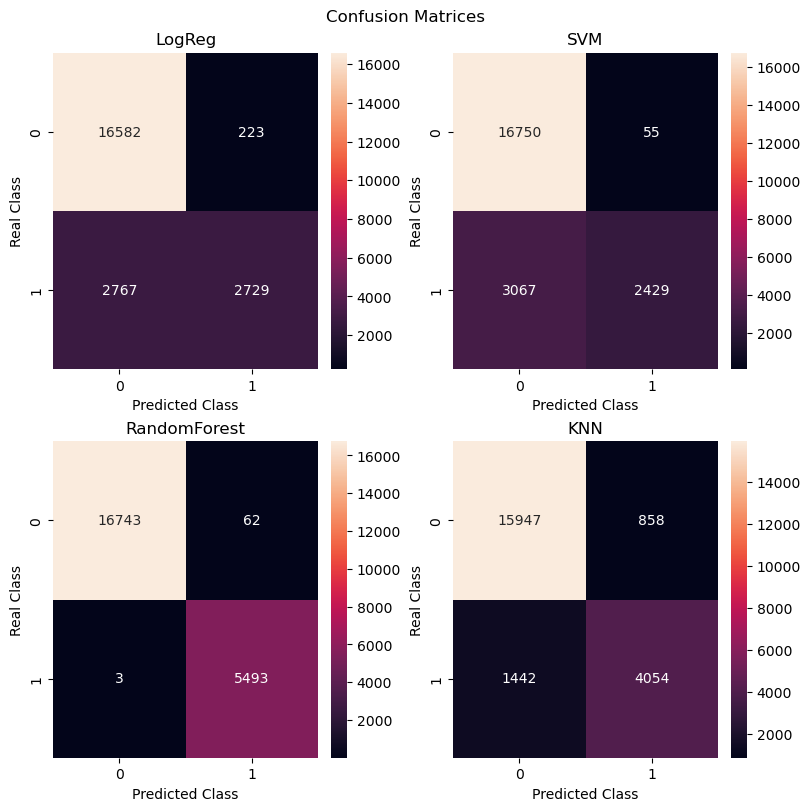

In [22]:
fig, axs = plt.subplots(2, 2, constrained_layout = True, figsize=(8, 8))

z = 0
plt.suptitle("Confusion Matrices")
for i in range(2):
    for j in range(2):
        sns.heatmap(Matrices[z], annot=True, fmt="d", ax=axs[i,j])
        axs[i,j].set_title(names[z])
        axs[i,j].set_xlabel("Predicted Class")
        axs[i,j].set_ylabel("Real Class")
        z += 1
plt.show()

As we could expect, the Random Forest performs the best job by a huge margin, followed by KNNs. SVMs and Logistic Regression seem to have an hard time predicting the 1 (defaulted) class.

Through the Random Forest, we can also check the importance of each feature in determining the loan's outcome:

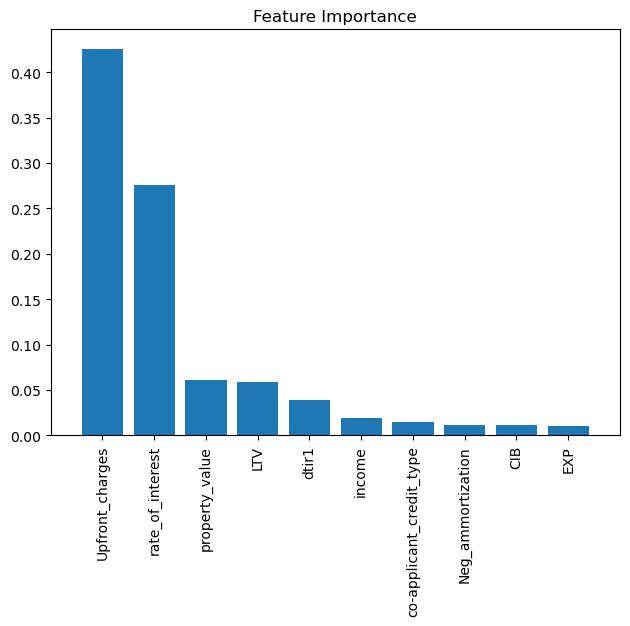

In [23]:
imps = rf.feature_importances_
idx = np.argsort(imps)[:-11:-1]
feat_labels = x_train.columns

plt.title("Feature Importance")
plt.bar(range(10),
        imps[idx])
plt.tight_layout()
plt.xticks(range(10), feat_labels[idx], rotation=90)
plt.xlim([-1, 10])
plt.show()

It seems that the most important features in predicting defaults are whether there were upfront charges and the rate of interest. <br> 
Other factors such as loan to value ratio and property value also play a role, although smaller. <br>
Non-economic variables like gender or age group dont't appear to have any significant relevance.